# Learning Entanglement by Confusion with XGBoost

In [1]:
import qiskit.quantum_info
import numpy as np 
import torch
from tqdm import tqdm
from progress.bar import IncrementalBar
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from xgboost import XGBClassifier

### SIC-POVM Measurements 

In [2]:
# Pauli matrices 
unity = qiskit.quantum_info.Operator([[1, 0], [0, 1]])
paulix = qiskit.quantum_info.Operator([[0, 1], [1, 0]])
pauliy = qiskit.quantum_info.Operator([[0, -1j], [1j, 0]])
pauliz = qiskit.quantum_info.Operator([[1, 0], [0, -1]])

# SIC-POVM definition 
p1 = 1/2 * (unity + 1/np.sqrt(3)*(paulix - pauliy + pauliz))
p2 = 1/2 * (unity + 1/np.sqrt(3)*(paulix + pauliy - pauliz))
p3 = 1/2 * (unity + 1/np.sqrt(3)*(- paulix + pauliy + pauliz))
p4 = 1/2 * (unity + 1/np.sqrt(3)*(- paulix - pauliy - pauliz))

sic_povm = [p1, p2, p3, p4]

In [3]:
povm_list = []
for povm1 in sic_povm:
    for povm2 in sic_povm:
        povm_list.append(povm1.tensor(povm2))
        
povm_list = np.array(povm_list)

# Number of operators 
povm_list.shape

(16,)

In [4]:
def POVM_measurement(state, povm):
    data = []
    for p in povm:
        data.append(np.real(1/4 * qiskit.quantum_info.DensityMatrix((state.to_operator()).__mul__(p)).trace()))
    return data

### States Generation 

In [5]:
def gen_max_ent_state(d_a, d_b):
    matrix = np.zeros((d_a * d_b) ** 2).reshape(d_a * d_b, d_a * d_b)
    matrix[0, 0], matrix[0, d_a * d_b - 1], matrix[d_a * d_b - 1, 0], matrix[d_a * d_b - 1, d_a * d_b -1 ] = 1, 1, 1, 1,
    ghz = 1/2 * qiskit.quantum_info.DensityMatrix(matrix)
    U_A = qiskit.quantum_info.random_unitary((d_a))
    U_B = qiskit.quantum_info.random_unitary((d_b))
    return qiskit.quantum_info.DensityMatrix(
        (U_A.tensor(U_B)).__mul__(ghz.to_operator()).__mul__(U_A.tensor(U_B).transpose().conjugate()))

In [6]:
def two_part_depolarization(state, p, d_a, d_b):
    return (state * (p) + qiskit.quantum_info.DensityMatrix(np.identity(d_a * d_b))*((1 - p)/(d_a * d_b)))

In [7]:
def single_qubit_depolarization(state, p):
    krauss_1 = np.sqrt(1 - 3/4 * p) * unity
    krauss_2 = np.sqrt(p / 4) * paulix
    krauss_3 = np.sqrt(p / 4) * pauliy
    krauss_4 = np.sqrt(p / 4) * pauliz
    #print(krauss_1 + krauss_2 + krauss_3 + krauss_4)
    
    state = state.to_operator()
    rho = (krauss_1.tensor(unity)).__mul__(
        state).__mul__((krauss_1.tensor(unity)).transpose().conjugate()) + (krauss_2.tensor(unity)).__mul__(
        state).__mul__((krauss_2.tensor(unity)).transpose().conjugate()) + (krauss_3.tensor(unity)).__mul__(
        state).__mul__((krauss_3.tensor(unity)).transpose().conjugate()) + (krauss_4.tensor(unity)).__mul__(
        state).__mul__((krauss_4.tensor(unity)).transpose().conjugate())
    
    return qiskit.quantum_info.DensityMatrix(rho)

### Data preparation  

In [8]:
def row_data_preparation(left, right, size, d_a, d_b, meas_flag=True, depol='twoQ'):
    data = []
    pars = []
    if meas_flag == True:
        for i in range(size):
            par = (right - left) * np.random.sample() + left
            if depol == 'twoQ':
                rand_rho = two_part_depolarization(gen_max_ent_state(d_a, d_b), par, d_a, d_b)
                meas_res = POVM_measurement(rand_rho, povm_list)
                data.append(meas_res)
                pars.append(par)
            else:
                print('Unknown depolarization channel')
    elif meas_flag == False:
        for i in range(size):
            par = (right - left) * np.random.sample() + left
            if depol == 'twoQ':
                rand_rho = two_part_depolarization(gen_max_ent_state(d_a, d_b), par, d_a, d_b).data.reshape((d_a * d_b)**2)
                res = np.concatenate((np.real(rand_rho), np.imag(rand_rho)))
                data.append(res)
                pars.append(par)
            else:
                print('Unknown depolarization channel')
    else:
        print('Unknown measurement flag')
    return np.array(data), np.array(pars)

In [9]:
def data_labeling(data, params, p_expect):
    labels = []
    for i in range(len(params)):
        if params[i] <= p_expect:
            labels.append(0.)
        else:
            labels.append(1.)
            
    data, labels = np.array(data), np.array(labels)
    
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    data = (data - data_mean) / (data_std + 0.01)
    
    return data, labels 

### Model 

In [33]:
def XGB_learning(data, labels):
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=7)
    
    # fit model no training data

    model = XGBClassifier()
    eval_set = [(data_train, labels_train), (data_test, labels_test)]
    model.fit(data_train, labels_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
    
    labels_pred = model.predict(data_test)
    predictions = [round(value) for value in labels_pred]
    
    results = model.evals_result()
    accuracy = accuracy_score(labels_test, predictions)
    learn_curve = 1 - np.array(results['validation_1']['error'])
    #print('Accuracy = ', accuracy)
                               
    return accuracy, learn_curve

### Output

In [34]:
def plot_learn_curves_cut(learn_curves, p_guess, x_true):
    fig = plt.figure()
    plt.rc('font', family='serif')
    cmap = plt.get_cmap('twilight')
    ax = fig.add_subplot(1, 1, 1)
    fig.set_size_inches(6, 3)
    leng = len(learn_curves[0, :])
    for i in range(leng):
        ax.plot(p_guess, learn_curves[:, i], color=cmap(float(i)/leng))
    ax.axvline(x=x_true)
    ax.set_xlabel('p', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.grid()
    plt.show()

In [35]:
def plot_wshape(wshapes, x_true, bar_flag=False):
    %matplotlib notebook
    fig = plt.figure()
    plt.rc('font', family='serif')
    ax = fig.add_subplot(1, 1, 1)
    fig.set_size_inches(6, 3.5)
    
    if bar_flag == True:
        for w_dat in wshapes:
            ax.errorbar(w_dat[0], w_dat[1], yerr=w_dat[2], linewidth=2, markersize=7, markeredgecolor='black', 
                        alpha=0.9, capsize=3, fmt='-o')
        #ax.plot(w_dat[0], w_dat[1], '-o', linewidth=4.5, markersize=10, markeredgecolor='black')
    elif bar_flag == False:
        for w_dat in wshapes:
            ax.plot(w_dat[0], w_dat[1], '-o', linewidth=2, markersize=7, markeredgecolor='black')
        

    ax.axvline(x=x_true)
    ax.set_xlabel('Depolarization parameter $p$', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_title('XGB Model')
    ax.grid()
    fig.savefig('wshape1.png', format='png', dpi=1000)

In [36]:
def w_shape_gen(p_guess, row_data, row_pars):
    w_data, learn_curves = [], []
    #bar = IncrementalBar('Countdown', max = len(p_guess))
    for p in tqdm(p_guess):
        data, labels = data_labeling(row_data, row_pars, p)
        acc, curve = XGB_learning(data, labels)
        w_data.append(acc)
        learn_curves.append(curve)
    return w_data, learn_curves

In [37]:
def mainloop(bounds, trials, data_size, d_a, d_b, dotn, meas_flag, dep_type):
    w_shape_data = []
    for bound in bounds:
        w_data_stack, learn_curves_data = [], []
        
        print('w-shape in bounds = ', bound)
        p_guess = np.linspace(bound[0], bound[1], dotn)
        
        for i in range(trials):
            #print('------- w-shape sample number =', i, '-------')
            row_data, row_labels = row_data_preparation(bound[0], bound[1], data_size, d_a, d_b, meas_flag, dep_type)
            w_data, learn_curves = w_shape_gen(p_guess, row_data, row_labels)
            
            w_data_stack.append(w_data)
            learn_curves_data.append(learn_curves)
        
        w_shape = np.mean(w_data_stack, axis=0)
        w_bar = np.std(w_data_stack, axis=0)
        learn_curves = np.mean(learn_curves_data, axis=0)
        
        w_shape_data.append([p_guess, w_shape, w_bar, learn_curves])
        
    return w_shape_data  

In [41]:
#bounds = [[-1/3, 5/6], [-1/4, 11/12], [-1/6, 1]]
bounds = [[-1/4, 1]]
samples = 10
data_size = int(0.25*10**3)
dots_number = 32
d_a, d_b = 3, 3

In [42]:
out = mainloop(bounds, samples, data_size, d_a, d_b, dots_number, False, 'twoQ')

w-shape in bounds =  [-0.25, 1]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.16it/s]


<IPython.core.display.Javascript object>


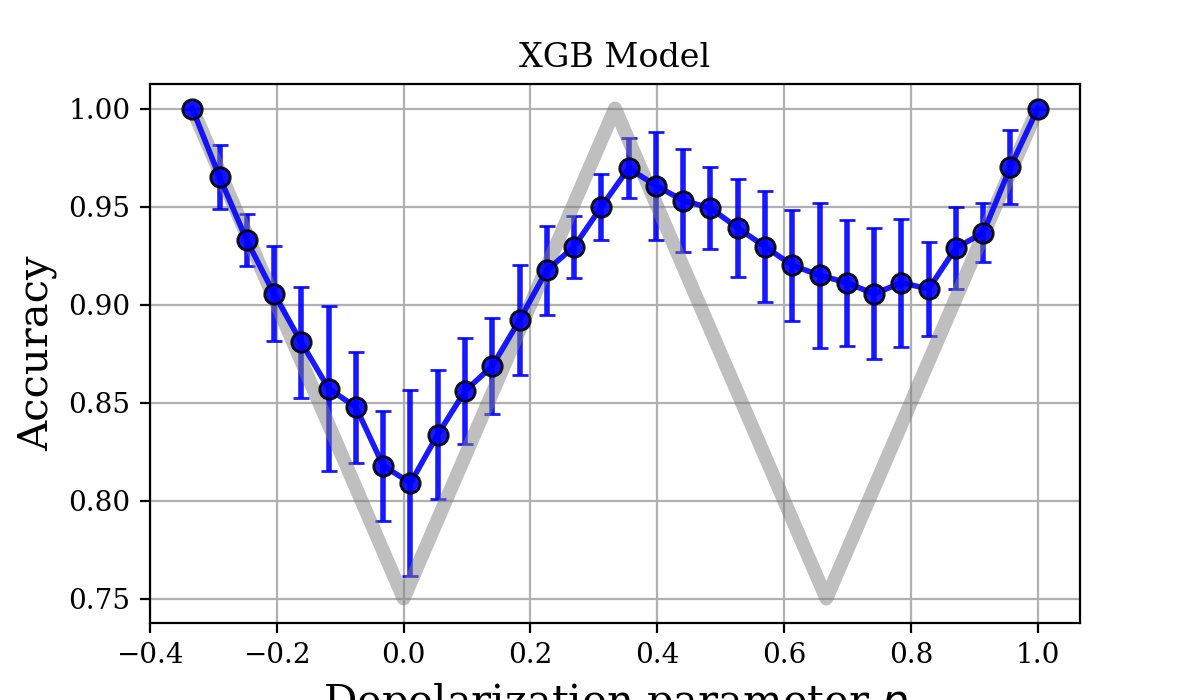

In [108]:
%matplotlib notebook
fig = plt.figure()
plt.rc('font', family='serif')
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(6, 3.5)
    
for w_dat in out:
    ax.errorbar(w_dat[0], w_dat[1], yerr=w_dat[2], linewidth=2, markersize=7, markeredgecolor='black', 
                alpha=0.9, capsize=3, fmt='-o', color='blue')
ax.plot([-1/3, 0, 1/3, 2/3, 1], [1, 0.75, 1, 0.75, 1], linewidth=5, alpha=0.5, color='gray')
#ax.axvline()
ax.set_xlabel('Depolarization parameter $p$', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_title('XGB Model')
ax.grid()
#fig.savefig('wshape1.png', format='png', dpi=1000)

<IPython.core.display.Javascript object>


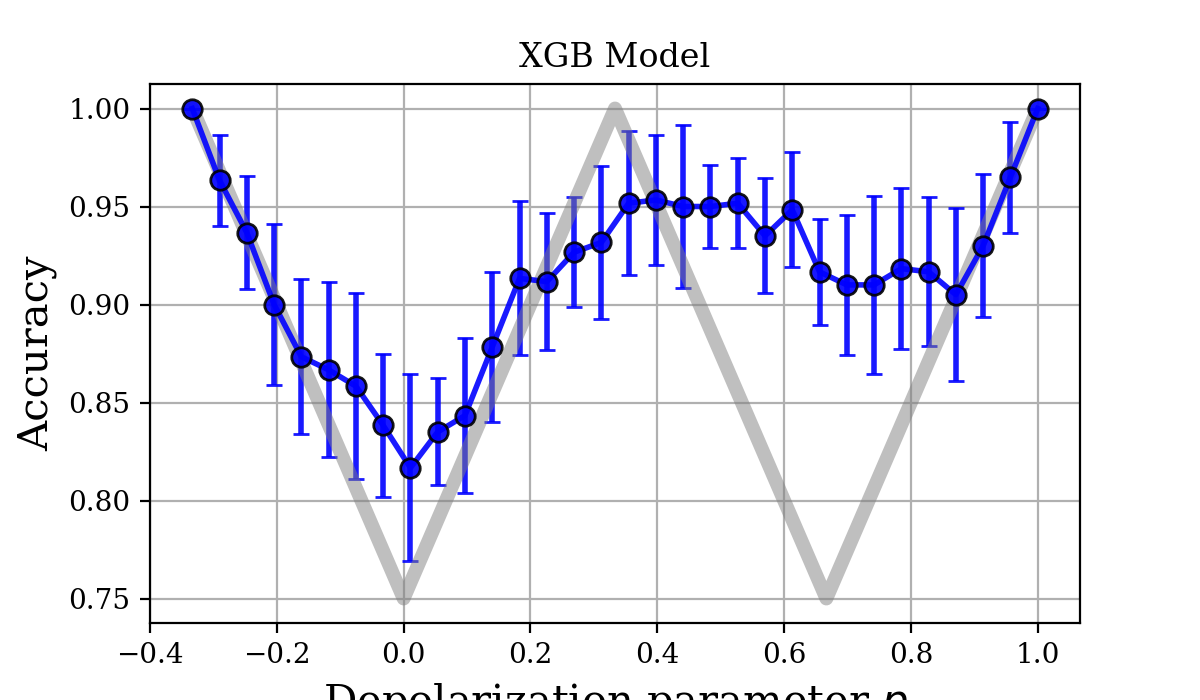

In [29]:
%matplotlib notebook
fig = plt.figure()
plt.rc('font', family='serif')
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(6, 3.5)
    
for w_dat in out:
    ax.errorbar(w_dat[0], w_dat[1], yerr=w_dat[2], linewidth=2, markersize=7, markeredgecolor='black', 
                alpha=0.9, capsize=3, fmt='-o', color='blue')
ax.plot([-1/3, 0, 1/3, 2/3, 1], [1, 0.75, 1, 0.75, 1], linewidth=5, alpha=0.5, color='gray')
#ax.axvline()
ax.set_xlabel('Depolarization parameter $p$', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_title('XGB Model')
ax.grid()
#fig.savefig('wshape2x2.png', format='png', dpi=1000)

<IPython.core.display.Javascript object>


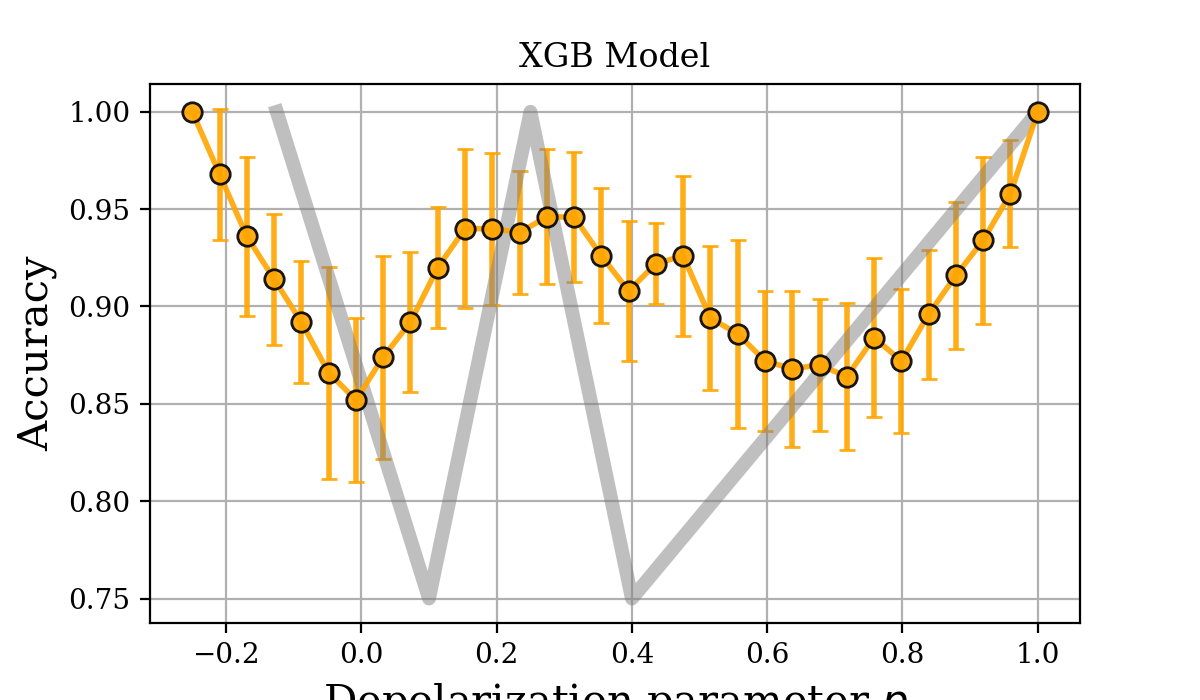

In [43]:
%matplotlib notebook
fig = plt.figure()
plt.rc('font', family='serif')
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(6, 3.5)
    
for w_dat in out:
    ax.errorbar(w_dat[0], w_dat[1], yerr=w_dat[2], linewidth=2, markersize=7, markeredgecolor='black', 
                alpha=0.9, capsize=3, fmt='-o', color='orange')
ax.plot([-1/8, 0.1, 1/4, 0.4, 1], [1, 0.75, 1, 0.75, 1], linewidth=5, alpha=0.5, color='gray')
#ax.axvline()
ax.set_xlabel('Depolarization parameter $p$', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_title('XGB Model')
ax.grid()
#fig.savefig('wshape2.png', format='png', dpi=1000)

In [44]:
rho = gen_max_ent_state(2, 2)

In [46]:
rho.trace()

(0.9999999999999999+0j)

In [60]:
rho2 = two_part_depolarization(rho, -1/2, 2, 2)

In [61]:
rho2.trace()

(1+0j)

In [62]:
qiskit.quantum_info.concurrence(rho2)

QiskitError: 'Input quantum state is not a valid'

In [143]:
import matplotlib.pyplot as plt
p = np.linspace(-1/5, 1, 100)
conc = []
neg = []
for i in range(len(p)):
    rho = two_part_depolarization(gen_max_ent_state(3, 2), p[i], 3, 2)
    conc.append(qiskit.quantum_info.concurrence(rho))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(6, 3)
ax.plot(p, conc)

QiskitError: 'Input density matrix must be a 2-qubit state.'